In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# # Load dataset
# file_path = "Dry_Eye_Dataset.csv"
# df = pd.read_csv(file_path)

# # Encode categorical features
# categorical_features = ['Gender', 'Sleep disorder', 'Wake up during night', 'Feel sleepy during day',
#                         'Caffeine consumption', 'Alcohol consumption', 'Smoking', 'Medical issue',
#                         'Ongoing medication', 'Smart device before bed', 'Blue-light filter',
#                         'Discomfort Eye-strain', 'Redness in eye', 'Itchiness/Irritation in eye', 'Dry Eye Disease']
# label_encoders = {}
# for col in categorical_features:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#     label_encoders[col] = le

# # Convert Blood Pressure into two separate numerical columns
# df[['Systolic_BP', 'Diastolic_BP']] = df['Blood pressure'].str.split('/', expand=True).astype(float)
# df.drop(columns=['Blood pressure'], inplace=True)

# # Define numerical features
# numerical_features = ['Age', 'Sleep duration', 'Sleep quality', 'Stress level', 'Heart rate', 'Daily steps',
#                       'Physical activity', 'Height', 'Weight', 'Average screen time', 'Systolic_BP', 'Diastolic_BP']

# # Standardize numerical features
# scaler = StandardScaler()
# df[numerical_features] = scaler.fit_transform(df[numerical_features])

# # Split data into features and target
# #X = df.drop(columns=['Dry Eye Disease'])
# #y = df['Dry Eye Disease']

# df.to_csv("Dry_Eye_Dataset_preprocessed.csv", index=False)

데이터 준비 완료.
Train: (12000, 26), Val: (4000, 26), Test: (4000, 26)
--------------------------------------------------
[분석 1] 클래스별 상관관계 분석...


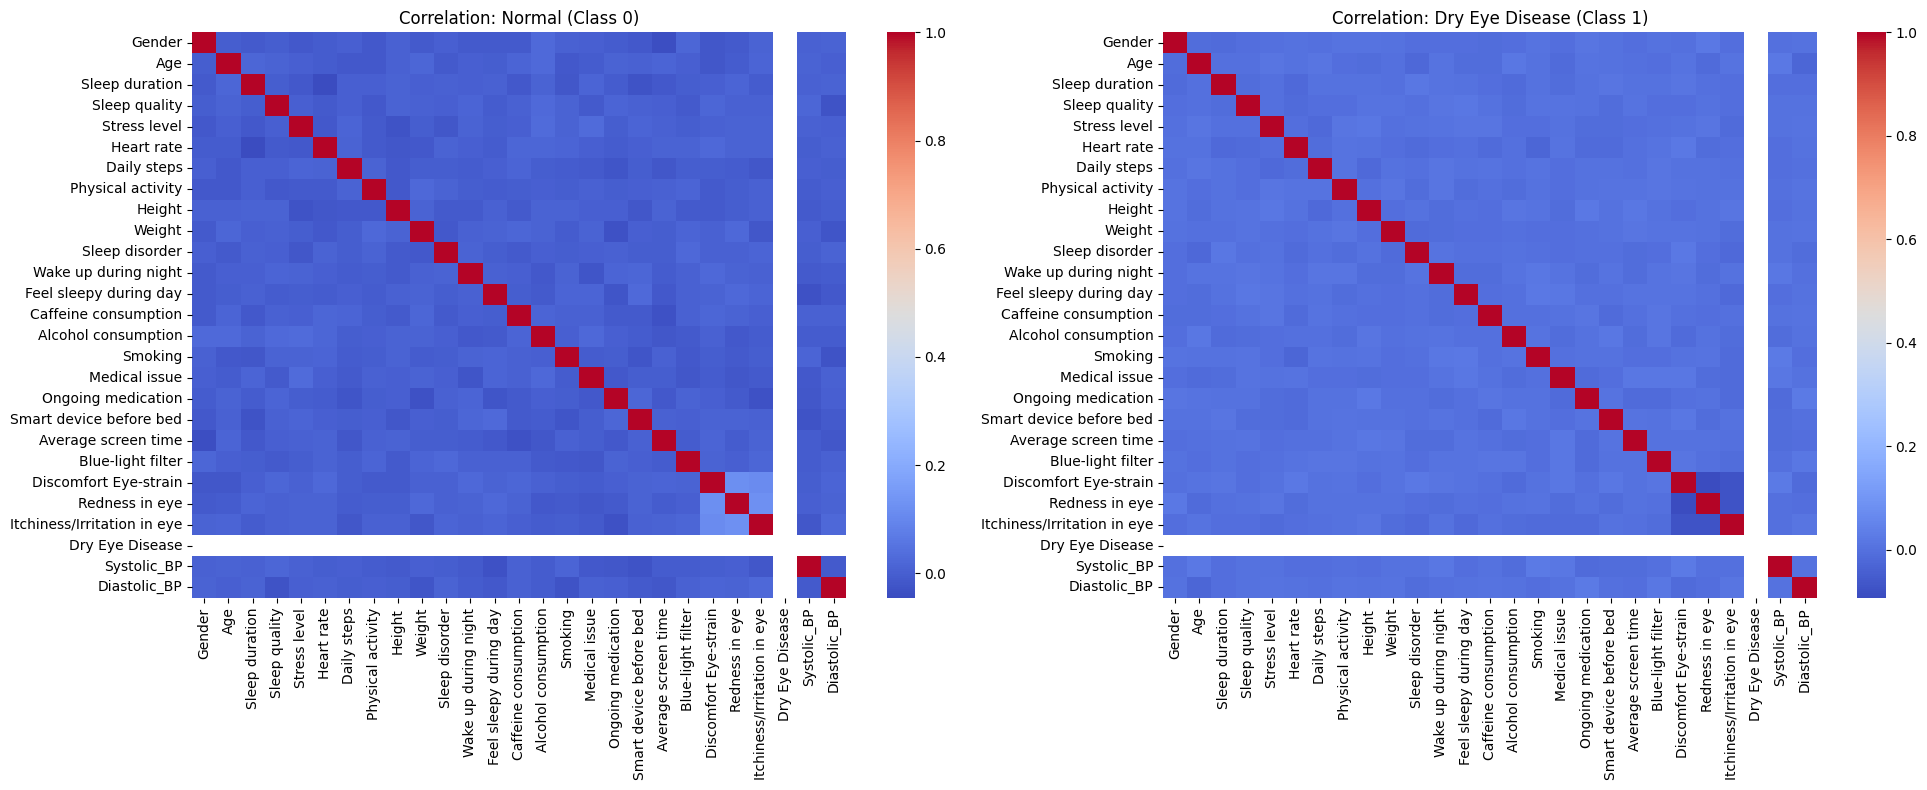

--------------------------------------------------
[분석 2] Early Stopping 적용 유무에 따른 성능 비교 실험
  >> Model A (No Early Stopping) 학습 중...
  >> Model B (With Early Stopping) 학습 중...


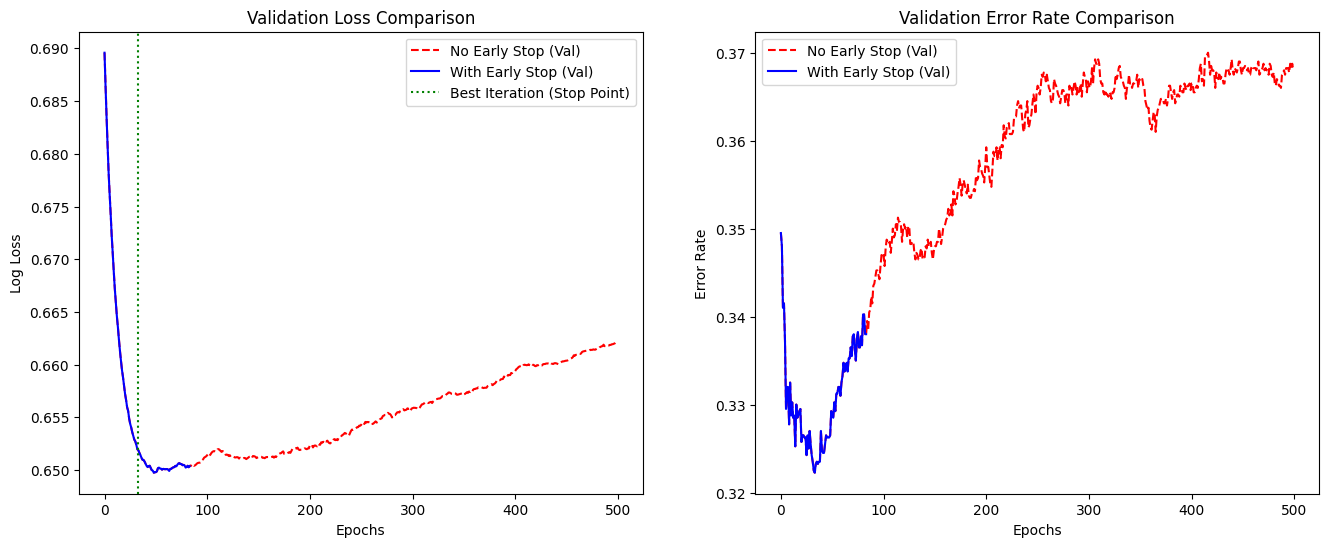


[결과 비교]
1. Early Stopping [OFF]: Accuracy = 0.6145, AUC = 0.5760
   -> 학습 횟수: 500회 (끝까지 감)
2. Early Stopping [ON] : Accuracy = 0.6498, AUC = 0.5828
   -> 학습 횟수: 84회 (최적점에서 멈춤)
--------------------------------------------------
[분석 3] Stratified K-Fold 교차 검증 (5-Fold)...
  Fold 1 Accuracy: 0.6727
  Fold 2 Accuracy: 0.6687
  Fold 3 Accuracy: 0.6633
  Fold 4 Accuracy: 0.6813
  Fold 5 Accuracy: 0.6677

평균 Accuracy: 0.6707 (±0.0061)
--------------------------------------------------
[분석 4] 최종 모델 상세 평가 (Early Stopping 모델 기준)


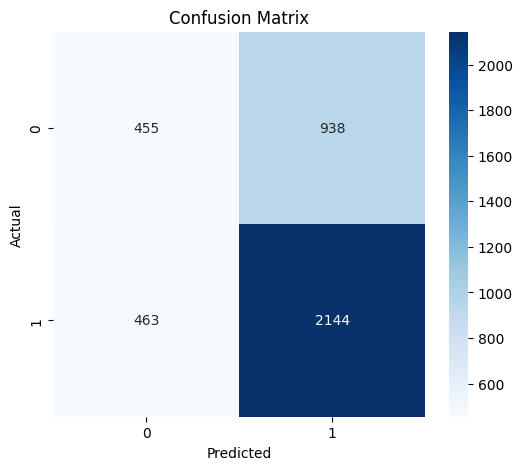

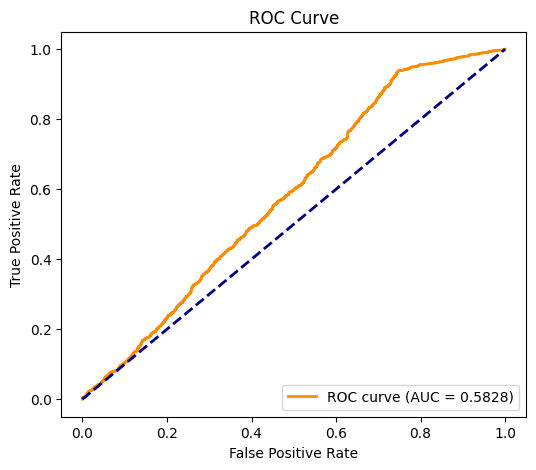

최종 Test AUC Score: 0.5828

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.33      0.39      1393
           1       0.70      0.82      0.75      2607

    accuracy                           0.65      4000
   macro avg       0.60      0.57      0.57      4000
weighted avg       0.63      0.65      0.63      4000



<Figure size 1000x800 with 0 Axes>

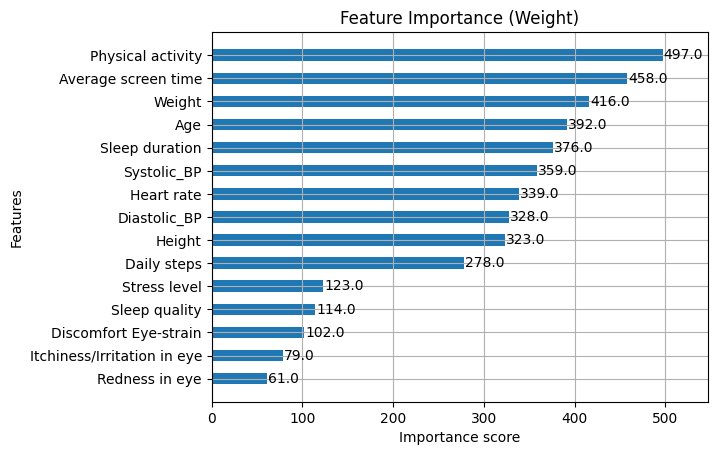

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFromModel

# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 데이터 로드 및 전처리
# ==========================================
df = pd.read_csv('Dry_Eye_Dataset_preprocessed.csv')

# Feature / Target 분리 (BP 변수 원본 유지)
X = df.drop('Dry Eye Disease', axis=1)
y = df['Dry Eye Disease']

# Train / Validation / Test 분리 (Stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

# 클래스 불균형 비율 계산 (Scale_pos_weight용)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

print("데이터 준비 완료.")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("-" * 50)


# ==========================================
# 2. 클래스별 상관관계 분석 (기존 내용 유지)
# ==========================================
print("[분석 1] 클래스별 상관관계 분석...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(df[df['Dry Eye Disease'] == 0].corr(), annot=False, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation: Normal (Class 0)')

sns.heatmap(df[df['Dry Eye Disease'] == 1].corr(), annot=False, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation: Dry Eye Disease (Class 1)')

plt.tight_layout()
plt.show()
print("-" * 50)


# ==========================================
# 3. [핵심] Early Stopping 적용 vs 미적용 비교 실험
# ==========================================
print("[분석 2] Early Stopping 적용 유무에 따른 성능 비교 실험")

# 공통 파라미터
common_params = {
    'n_estimators': 500,      # 과적합을 확인하기 위해 넉넉하게 설정
    'learning_rate': 0.05,
    'max_depth': 6,
    'scale_pos_weight': ratio, # 불균형 보정
    'eval_metric': ["logloss", "error"],
    'random_state': 42,
    'n_jobs': -1
}

# --- Model A: Early Stopping 없음 (No ES) ---
print("  >> Model A (No Early Stopping) 학습 중...")
model_no_es = xgb.XGBClassifier(**common_params) # early_stopping_rounds 없음
model_no_es.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# --- Model B: Early Stopping 적용 (With ES) ---
print("  >> Model B (With Early Stopping) 학습 중...")
model_es = xgb.XGBClassifier(early_stopping_rounds=50, **common_params) # 50회 인내심 설정
model_es.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# --- 비교 결과 시각화 ---
results_no = model_no_es.evals_result()
results_es = model_es.evals_result()
epochs_no = len(results_no['validation_0']['logloss'])
epochs_es = len(results_es['validation_0']['logloss'])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 그래프 1: Validation Logloss 비교
ax[0].plot(range(epochs_no), results_no['validation_1']['logloss'], label='No Early Stop (Val)', color='red', linestyle='--')
ax[0].plot(range(epochs_es), results_es['validation_1']['logloss'], label='With Early Stop (Val)', color='blue')
ax[0].axvline(model_es.best_iteration, color='green', linestyle=':', label='Best Iteration (Stop Point)')
ax[0].set_title('Validation Loss Comparison')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log Loss')
ax[0].legend()

# 그래프 2: Validation Error (1-Accuracy) 비교
ax[1].plot(range(epochs_no), results_no['validation_1']['error'], label='No Early Stop (Val)', color='red', linestyle='--')
ax[1].plot(range(epochs_es), results_es['validation_1']['error'], label='With Early Stop (Val)', color='blue')
ax[1].set_title('Validation Error Rate Comparison')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error Rate')
ax[1].legend()

plt.show()

# --- 수치 비교 출력 ---
# Test 셋에 대한 최종 평가
pred_no = model_no_es.predict(X_test)
pred_es = model_es.predict(X_test)
auc_no = roc_auc_score(y_test, model_no_es.predict_proba(X_test)[:, 1])
auc_es = roc_auc_score(y_test, model_es.predict_proba(X_test)[:, 1])

print(f"\n[결과 비교]")
print(f"1. Early Stopping [OFF]: Accuracy = {accuracy_score(y_test, pred_no):.4f}, AUC = {auc_no:.4f}")
print(f"   -> 학습 횟수: {epochs_no}회 (끝까지 감)")
print(f"2. Early Stopping [ON] : Accuracy = {accuracy_score(y_test, pred_es):.4f}, AUC = {auc_es:.4f}")
print(f"   -> 학습 횟수: {epochs_es}회 (최적점에서 멈춤)")
print("-" * 50)


# ==========================================
# 4. Stratified K-Fold CV (기존 내용 유지)
# ==========================================
print("[분석 3] Stratified K-Fold 교차 검증 (5-Fold)...")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_k_train, X_k_val = X.iloc[train_idx], X.iloc[val_idx]
    y_k_train, y_k_val = y.iloc[train_idx], y.iloc[val_idx]

    # K-Fold 모델 (Early Stopping 적용된 설정 사용 권장)
    model_cv = xgb.XGBClassifier(early_stopping_rounds=50, **common_params)

    # K-Fold 내부에서 또 split을 할 수 없으니 여기선 eval_set을 test fold로 씁니다 (간약화)
    model_cv.fit(
        X_k_train, y_k_train,
        eval_set=[(X_k_val, y_k_val)],
        verbose=False
    )

    acc = accuracy_score(y_k_val, model_cv.predict(X_k_val))
    cv_accuracies.append(acc)
    print(f"  Fold {fold+1} Accuracy: {acc:.4f}")

print(f"\n평균 Accuracy: {np.mean(cv_accuracies):.4f} (±{np.std(cv_accuracies):.4f})")
print("-" * 50)


# ==========================================
# 5. 최종 모델 평가 (Confusion Matrix, ROC, Feature Importance)
# ==========================================
print("[분석 4] 최종 모델 상세 평가 (Early Stopping 모델 기준)")

# 예측값 (Model B 사용)
final_pred = pred_es
final_probs = model_es.predict_proba(X_test)[:, 1]

# 1) Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2) ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, final_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"최종 Test AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, final_pred))

# 3) Feature Importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_es, max_num_features=15, importance_type='weight', title='Feature Importance (Weight)', height=0.5)
plt.show()

>>> [분석] 잡음 변수 제거 및 핵심 변수 탐색 중 (RFECV)...
최적 변수 개수: 3
선택된 변수 목록: ['Discomfort Eye-strain', 'Redness in eye', 'Itchiness/Irritation in eye']

>>> [학습] 선택된 변수로 모델 재학습...
--------------------------------------------------
[결과] Feature Selection 후 성능
Accuracy: 0.7005
AUC Score: 0.6088
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.26      0.37      1393
           1       0.70      0.94      0.80      2607

    accuracy                           0.70      4000
   macro avg       0.70      0.60      0.59      4000
weighted avg       0.70      0.70      0.65      4000



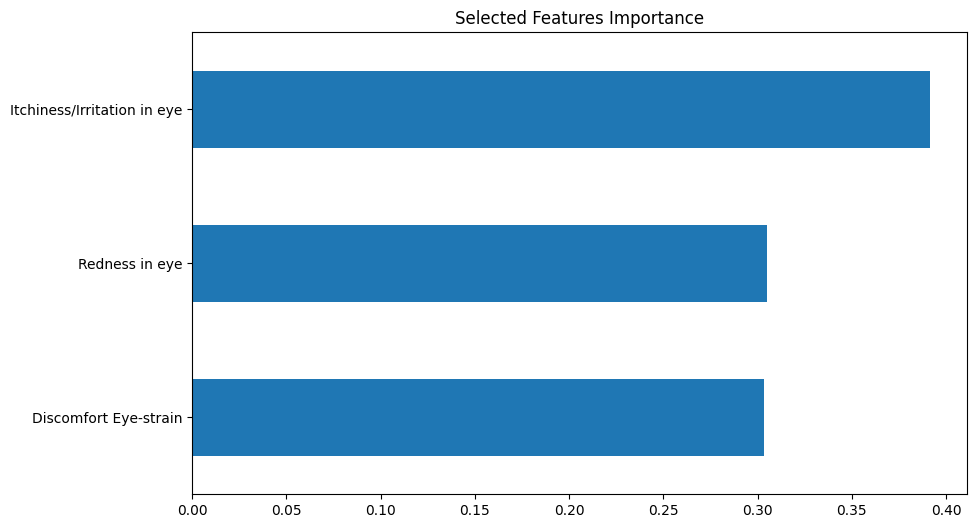

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import RFECV

# 한글 폰트 설정
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
df = pd.read_csv('Dry_Eye_Dataset_preprocessed.csv')
X = df.drop('Dry Eye Disease', axis=1)
y = df['Dry Eye Disease']

# 2. Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. [핵심] RFECV를 이용한 중요 변수 선별 (잡음 제거)
print(">>> [분석] 잡음 변수 제거 및 핵심 변수 탐색 중 (RFECV)...")

# 변수 선택용 모델
clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

# 5-Fold 교차검증으로 변수 중요도 평가
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

print(f"최적 변수 개수: {rfecv.n_features_}")
selected_features = X.columns[rfecv.support_]
print(f"선택된 변수 목록: {list(selected_features)}")

# 4. 선택된 변수로만 재학습 (모델 다이어트)
print("\n>>> [학습] 선택된 변수로 모델 재학습...")
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 수정됨: early_stopping_rounds를 생성자로 이동
model_final = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50  # <--- 여기로 이동 (에러 해결)
)

model_final.fit(
    X_train_selected, y_train,
    eval_set=[(X_test_selected, y_test)],
    verbose=False
)

# 5. 결과 확인
pred = model_final.predict(X_test_selected)
probs = model_final.predict_proba(X_test_selected)[:, 1]

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, probs)

print("-" * 50)
print(f"[결과] Feature Selection 후 성능")
print(f"Accuracy: {acc:.4f}")
print(f"AUC Score: {auc:.4f}")
print("-" * 50)
print(classification_report(y_test, pred))

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
importance = pd.Series(model_final.feature_importances_, index=selected_features)
importance.sort_values(ascending=True).plot.barh()
plt.title('Selected Features Importance')
plt.show()

>>> [진짜 중요 변수 Top 12 선정 완료]
['Itchiness/Irritation in eye', 'Discomfort Eye-strain', 'Redness in eye', 'Age', 'Feel sleepy during day', 'Sleep quality', 'Sleep duration', 'Average screen time', 'Weight', 'Physical activity', 'Medical issue', 'Heart rate']


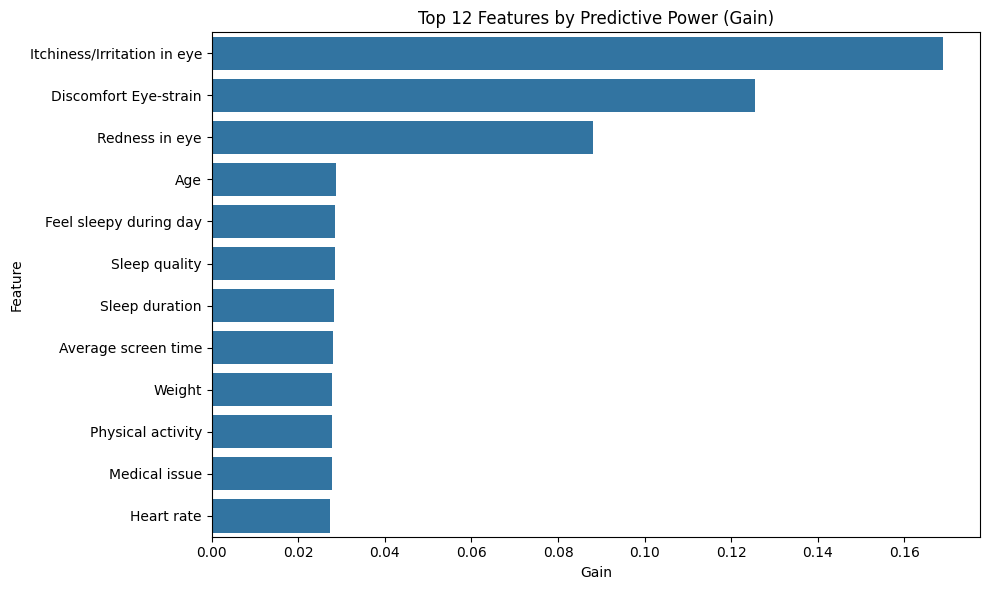


>>> [학습] 선별된 변수로 최종 모델 학습 중...
--------------------------------------------------
[결과] Top 12 Features 선택 후 성능
Accuracy: 0.7000
AUC Score: 0.5925
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.25      0.37      1393
           1       0.70      0.94      0.80      2607

    accuracy                           0.70      4000
   macro avg       0.69      0.60      0.59      4000
weighted avg       0.70      0.70      0.65      4000



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 한글 폰트 설정
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
df = pd.read_csv('Dry_Eye_Dataset_preprocessed.csv')
X = df.drop('Dry Eye Disease', axis=1)
y = df['Dry Eye Disease']

# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. [핵심] 중요도 기준을 'Gain'(정보 획득량)으로 변경하여 진짜 중요 변수 탐색
# Weight(빈도)가 아니라 Gain(품질)을 봐야 연속형 변수의 거품이 빠집니다.
model_check = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model_check.fit(X_train, y_train, verbose=False)

# Gain 기준 중요도 추출
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Gain': model_check.feature_importances_ # XGBClassifier 기본 속성은 Gain 기반
})
importance_df = importance_df.sort_values(by='Gain', ascending=False)

# 상위 12개 변수만 선택
top_n = 12
selected_features = importance_df['Feature'].head(top_n).tolist()

print(f">>> [진짜 중요 변수 Top {top_n} 선정 완료]")
print(selected_features)

# 시각화: 진짜 중요도(Gain) 확인
plt.figure(figsize=(10, 6))
sns.barplot(x='Gain', y='Feature', data=importance_df.head(top_n))
plt.title(f'Top {top_n} Features by Predictive Power (Gain)')
plt.tight_layout()
plt.show()

# 3. 선별된 변수로 최종 모델 학습
print("\n>>> [학습] 선별된 변수로 최종 모델 학습 중...")
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# [수정 완료] early_stopping_rounds를 생성자 내부로 이동
final_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50  # <--- 여기로 이동했습니다
)

final_model.fit(
    X_train_selected, y_train,
    eval_set=[(X_test_selected, y_test)],
    verbose=False
)

# 4. 결과 확인
pred = final_model.predict(X_test_selected)
probs = final_model.predict_proba(X_test_selected)[:, 1]

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, probs)

print("-" * 50)
print(f"[결과] Top {top_n} Features 선택 후 성능")
print(f"Accuracy: {acc:.4f}")
print(f"AUC Score: {auc:.4f}")
print("-" * 50)
print(classification_report(y_test, pred))

[Step 1] 데이터 로드 및 SHAP 분석을 위한 Base 학습...
 >> SHAP Value 계산 중... (시간이 조금 걸릴 수 있습니다)
 >> SHAP 선정 Top 12 변수: ['Discomfort Eye-strain', 'Redness in eye', 'Itchiness/Irritation in eye', 'Physical activity', 'Average screen time', 'Sleep duration', 'Systolic_BP', 'Weight', 'Height', 'Diastolic_BP', 'Age', 'Heart rate']


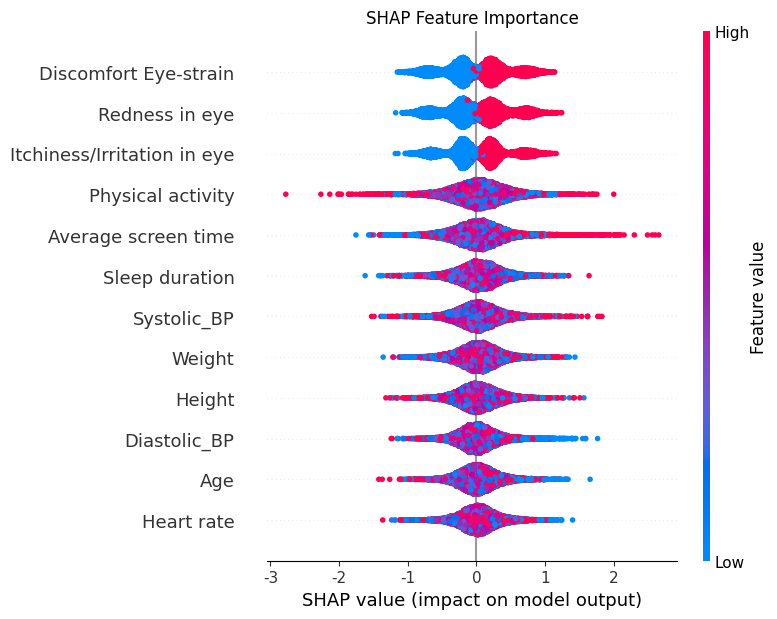


[Step 2] Optuna 최적화 시작 (Target: Overfitting 최소화 & AUC 극대화)
 >> Best Val AUC: 0.6144
 >> Best Params: {'n_estimators': 633, 'learning_rate': 0.02261338077823376, 'max_depth': 3, 'subsample': 0.5012475900322455, 'colsample_bytree': 0.6453860784873711, 'gamma': 3.53210370618259, 'reg_alpha': 0.1267471176049656, 'reg_lambda': 2.203612131989603}

[Step 3] 최종 모델 학습 및 평가 (Train vs Test Gap 확인)
------------------------------------------------------------
Train Accuracy : 0.6974
Test Accuracy  : 0.7005
Test AUC Score : 0.6032
GAP (Train-Test): -0.0031
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.26      0.37      1393
           1       0.70      0.94      0.80      2607

    accuracy                           0.70      4000
   macro avg       0.70      0.60      0.59      4000
weighted avg       0.70      0.70      0.65      4000



In [15]:
# 1. 필요 라이브러리 설치 및 임포트
try:
    import shap
except ImportError:
    print("SHAP 라이브러리 설치 중...")
    !pip install shap
    import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 한글 폰트 및 시각화 설정
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False
optuna.logging.set_verbosity(optuna.logging.WARNING)

# -------------------------------------------------------
# 1. 데이터 로드 및 Base 모델 학습 (SHAP 추출용)
# -------------------------------------------------------
print("[Step 1] 데이터 로드 및 SHAP 분석을 위한 Base 학습...")
df = pd.read_csv('Dry_Eye_Dataset_preprocessed.csv')
X = df.drop('Dry Eye Disease', axis=1)
y = df['Dry Eye Disease']

# Train/Test/Val 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# SHAP 분석용 기본 모델 (일부러 과적합 되게 둬서 모든 변수 탐색)
base_model = xgb.XGBClassifier(
    n_estimators=300, max_depth=6, random_state=42, n_jobs=-1,
    tree_method='hist' # 속도 향상
)
base_model.fit(X_train, y_train)

# -------------------------------------------------------
# 2. SHAP Value 기반 Feature Selection
# -------------------------------------------------------
print(" >> SHAP Value 계산 중... (시간이 조금 걸릴 수 있습니다)")
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_train)

# 변수별 SHAP 절대값 평균 계산 (글로벌 중요도)
# shap_values가 list로 나오는 경우(구버전)와 array로 나오는 경우 처리
if isinstance(shap_values, list):
    vals = np.abs(shap_values[1]).mean(0)
else:
    vals = np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

# 상위 12개 선정 (사용자 요청대로 확실한 근거 기반)
top_n = 12
selected_features = feature_importance['col_name'].head(top_n).tolist()
print(f" >> SHAP 선정 Top {top_n} 변수: {selected_features}")

# SHAP Summary Plot (상위 12개만)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=X.columns, max_display=top_n, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# 선택된 변수로 데이터셋 교체
X_train_opt = X_train_sub[selected_features]
X_val_opt = X_val[selected_features]
X_test_opt = X_test[selected_features]

# -------------------------------------------------------
# 3. Optuna: 과적합 방지(Dropout 효과) 파라미터 집중 튜닝
# -------------------------------------------------------
print(f"\n[Step 2] Optuna 최적화 시작 (Target: Overfitting 최소화 & AUC 극대화)")

def objective(trial):
    # [핵심] Dropout 효과 및 규제 파라미터 탐색 범위 설정
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 6), # 깊이 제한

        # >> Dropout과 유사한 효과를 내는 파라미터들 <<
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),        # Row Sampling (데이터 일부만 사용)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9), # Feature Sampling (변수 일부만 사용)

        # >> 규제 (Regularization) <<
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),                # 리프 노드 분할을 위한 최소 손실 감소분
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),  # L1 규제
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True), # L2 규제

        # 고정값
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 50 # 생성자 내부로 이동
    }

    model = xgb.XGBClassifier(**params)

    # Train 데이터로 학습, Validation 데이터로 검증
    model.fit(
        X_train_opt, y_train_sub,
        eval_set=[(X_val_opt, y_val)],
        verbose=False
    )

    # Metric: AUC (불균형 데이터에서 Accuracy보다 신뢰도 높음)
    probs = model.predict_proba(X_val_opt)[:, 1]
    auc = roc_auc_score(y_val, probs)

    return auc

# 30회 탐색
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print(f" >> Best Val AUC: {study.best_value:.4f}")
best_params = study.best_params
print(" >> Best Params:", best_params)

# -------------------------------------------------------
# 4. 최적 모델 최종 학습 및 평가
# -------------------------------------------------------
print("\n[Step 3] 최종 모델 학습 및 평가 (Train vs Test Gap 확인)")

# Best Params로 재학습 (전체 Train set 사용)
final_model = xgb.XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

final_model.fit(
    X_train[selected_features], y_train,
    eval_set=[(X_test_opt, y_test)], # Test 셋을 검증용으로 사용하여 최종 성능 체크
    verbose=False
)

# Train vs Test Score 비교 (과적합 해소 확인)
train_pred = final_model.predict(X_train[selected_features])
test_pred = final_model.predict(X_test_opt)
test_probs = final_model.predict_proba(X_test_opt)[:, 1]

print("-" * 60)
print(f"Train Accuracy : {accuracy_score(y_train, train_pred):.4f}")
print(f"Test Accuracy  : {accuracy_score(y_test, test_pred):.4f}")
print(f"Test AUC Score : {roc_auc_score(y_test, test_probs):.4f}")
print(f"GAP (Train-Test): {accuracy_score(y_train, train_pred) - accuracy_score(y_test, test_pred):.4f}")
print("-" * 60)
print(classification_report(y_test, test_pred))